<a href="https://colab.research.google.com/github/omkar-desai-7972/CPU_SCHEDULING_UPDATED/blob/main/LSTM_CAPSTONE_MODEL_19_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving final.csv to final (4).csv
Loaded File: final (4).csv
Dataset Shape: (43989, 5)
Mapped Classes: ['H' 'I' 'B' 'O']
Feature Shape: (334, 9)
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1876 - loss: 1.5935 - val_accuracy: 0.2985 - val_loss: 1.5108
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3719 - loss: 1.4759 - val_accuracy: 0.4627 - val_loss: 1.4263
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4279 - loss: 1.4081 - val_accuracy: 0.4925 - val_loss: 1.3561
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4454 - loss: 1.3691 - val_accuracy: 0.5075 - val_loss: 1.2926
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4688 - loss: 1.3173 - val_accuracy: 0.5522 - val_loss: 1.2298
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5400 - loss: 1.2483 - val_accuracy: 0.5522 - val_loss: 1.1627
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5551 - loss: 1.1869 - val_accuracy: 0.5522

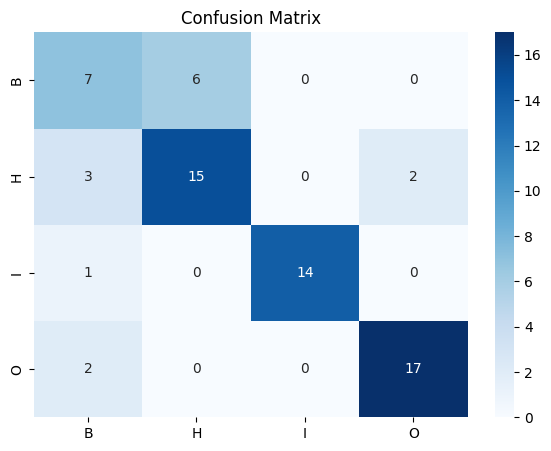

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# ===============================
# INSTALL DEPENDENCIES
# ===============================
!pip install pywavelets

# ===============================
# IMPORTS
# ===============================
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from google.colab import files
import io
import pickle

# ===============================
# UPLOAD CSV
# ===============================
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("Loaded File:", fname)

df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Dataset Shape:", df.shape)

# ===============================
# CLEAN LABELS → H,B,I,O,C
# ===============================
def map_label(x):
    if isinstance(x, str):
        if x.startswith("H"): return "H"
        if "_B" in x or x.startswith("B"): return "B"
        if "_I" in x or x.startswith("I"): return "I"
        if "_O" in x or x.startswith("O"): return "O"
        if "C" in x: return "C"
    return None

df["Class"] = df["Output"].apply(map_label)
df = df.dropna(subset=["Class"])   # remove unrecognized labels
print("Mapped Classes:", df["Class"].unique())

# ===============================
# FEATURE EXTRACTION (FFT)
# ===============================
def extract_fft_features(signal):
    signal = np.array(signal).astype(float)
    fft_vals = np.abs(np.fft.rfft(signal))
    return np.concatenate([
        [np.mean(fft_vals), np.std(fft_vals), np.max(fft_vals)]
    ])

features = []
labels = []

window = 256
stride = 128

for i in range(0, len(df) - window, stride):
    x = df["X"].values[i:i+window]
    y = df["Y"].values[i:i+window]
    z = df["Z"].values[i:i+window]

    feat = np.concatenate([
        extract_fft_features(x),
        extract_fft_features(y),
        extract_fft_features(z)
    ])

    features.append(feat)
    labels.append(df["Class"].iloc[i])

X = np.array(features)
y = np.array(labels)

print("Feature Shape:", X.shape)

# ===============================
# ENCODE + SCALE
# ===============================
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ===============================
# TRAIN TEST SPLIT
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42
)

# ===============================
# BUILD MODEL
# ===============================
model = Sequential([
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(5, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# ===============================
# TRAIN
# ===============================
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# ===============================
# EVALUATE
# ===============================
y_pred = np.argmax(model.predict(X_test), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.show()

# ===============================
# SAVE MODEL + SCALER + ENCODER
# ===============================
model.save("fault_classifier.h5")
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

files.download("fault_classifier.h5")
files.download("scaler.pkl")
files.download("encoder.pkl")


Saving Ball.csv to Ball (1).csv
Loaded: Ball (1).csv (5295, 4)
Feature vector shape: (1, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

🔥 FINAL PREDICTION: H



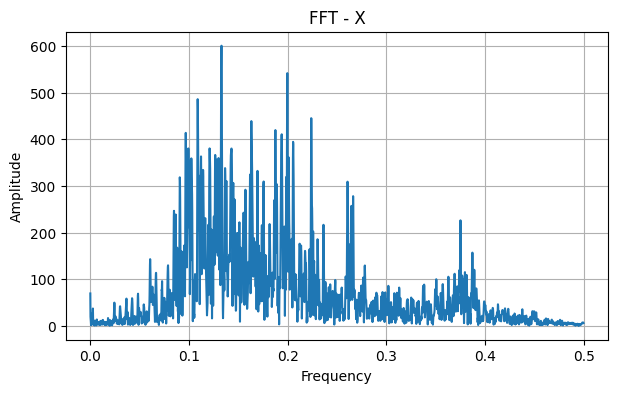

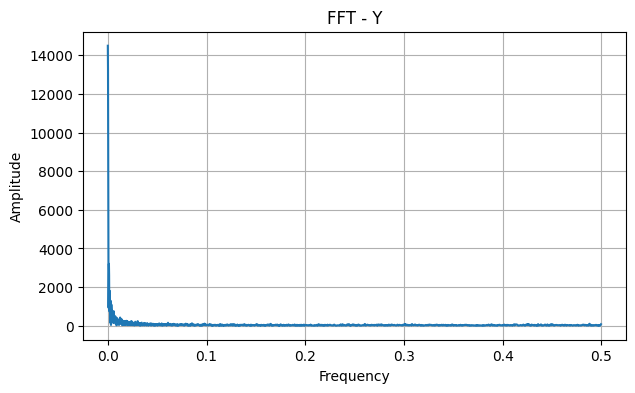

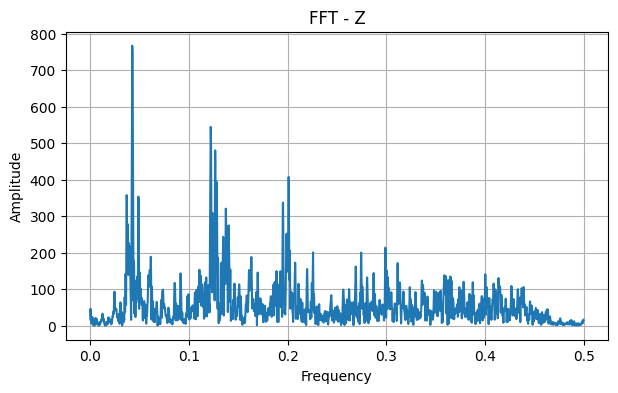

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import joblib
from google.colab import files

uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)

print("Loaded:", csv_name, df.shape)

# Load saved items
model = tf.keras.models.load_model("/content/fault_classifier.h5")
scaler = joblib.load("/content/scaler.pkl")
label_encoder = joblib.load("/content/encoder.pkl")

# ============================
# FEATURE EXTRACTION FUNCTIONS
# ============================

def rms_feature(signal):
    return np.sqrt(np.mean(signal**2))

def fft_energy(signal):
    fft_vals = np.abs(np.fft.fft(signal))
    return np.sum(fft_vals**2)

def wavelet_energy(signal):
    coeffs = pywt.wavedec(signal, 'db4', level=3)
    return sum(np.sum(c**2) for c in coeffs)

def extract_all_features(df):

    X = df["X"].values
    Y = df["Y"].values
    Z = df["Z"].values

    features = [
        rms_feature(X), rms_feature(Y), rms_feature(Z),
        fft_energy(X), fft_energy(Y), fft_energy(Z),
        wavelet_energy(X), wavelet_energy(Y), wavelet_energy(Z)
    ]

    return np.array(features).reshape(1, -1)

# Extract 9 features
features = extract_all_features(df)
print("Feature vector shape:", features.shape)

# Scale 9 features
features_scaled = scaler.transform(features)

# ❗ FIXED: Correct shape for Dense model
features_scaled = features_scaled.reshape(1, 9)

# Prediction
pred = model.predict(features_scaled)
label = label_encoder.inverse_transform([np.argmax(pred)])[0]

print("\n=============================")
print("🔥 FINAL PREDICTION:", label)
print("=============================\n")

# FFT plots
def plot_fft(sig, title):
    N = len(sig)
    fft_vals = np.abs(np.fft.fft(sig))
    freq = np.fft.fftfreq(N, 1.0)

    plt.figure(figsize=(7,4))
    plt.plot(freq[:N//2], fft_vals[:N//2])
    plt.title("FFT - " + title)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

plot_fft(df["X"], "X")
plot_fft(df["Y"], "Y")
plot_fft(df["Z"], "Z")


Loading: /content/final.csv
Raw shape: (43989, 5)
Sample labels (unique): ['H_20Hz' 'H_25Hz' 'H_30Hz' 'H_35Hz' 'H_40Hz' 'H_60Hz' 'H_65Hz' 'H_70Hz'
 'H_75Hz' 'H_80Hz' 'H_VS_0_40_0' '0.5X_I_20Hz' 'I_1/2_vs_0_40_2'
 '0.5X_I_25Hz' '0.5X_I_30Hz' '0.5X_I_35Hz' '0.5X_I_40Hz' '0.5X_I_60Hz'
 '0.5X_I_65Hz' '0.5X_I_70Hz']
Mapped classes (value counts):
Class
I       10999
B       10999
H       10989
O       10000
None     1002
Name: count, dtype: int64
After dropna shape: (42987, 6)
Windowing and feature extraction (window=256 stride=128)...
Total windows: 334 Feature dim: 39
Class mapping: {np.str_('B'): 0, np.str_('H'): 1, np.str_('I'): 2, np.str_('O'): 3}
B count: 86
H count: 85
I count: 86
O count: 77
Train/test shapes: (267, 39) (67, 39)
Training RandomForest...

Classification Report:
              precision    recall  f1-score   support

           B       0.84      0.94      0.89        17
           H       0.89      0.94      0.91        17
           I       0.94      0.94      0.94   

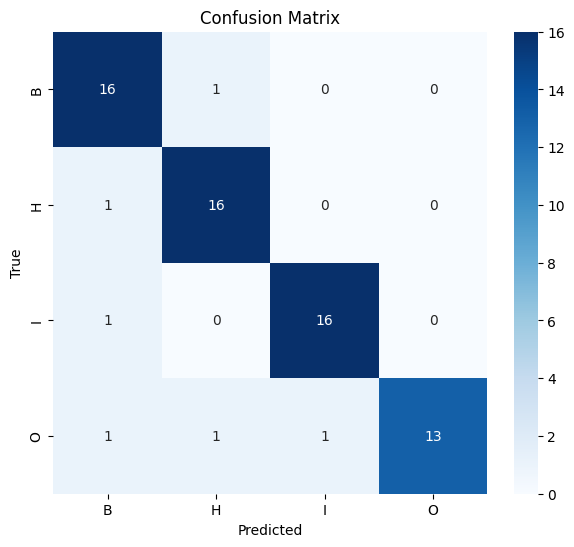

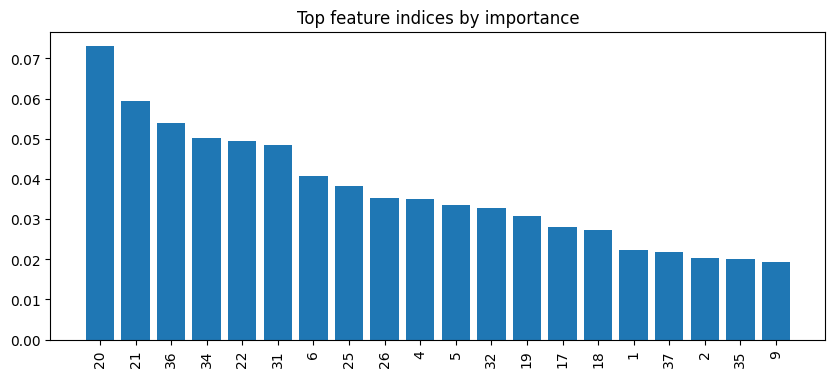

Saved rf_model.joblib, scaler.joblib, label_encoder.joblib
Testing: Ball.csv
Window predictions distribution: Counter({np.str_('B'): 29, np.str_('I'): 6, np.str_('H'): 5})
Majority prediction: B
Showing FFTs for first window


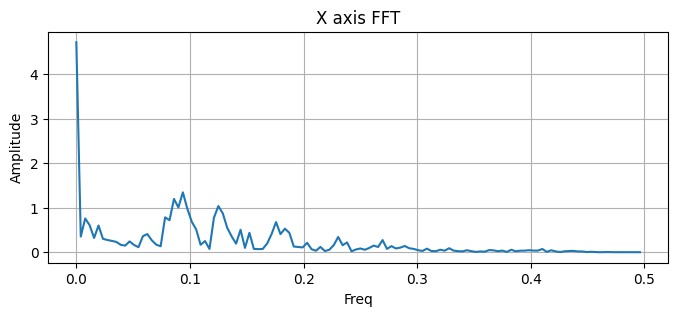

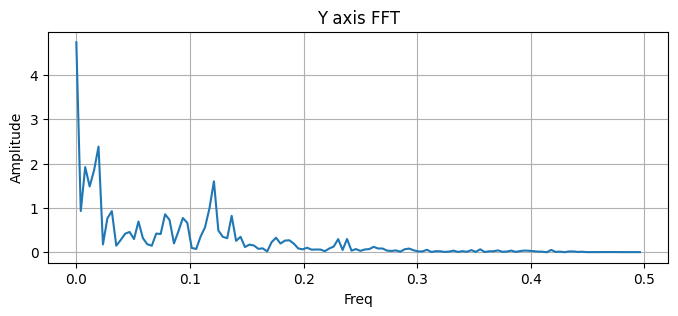

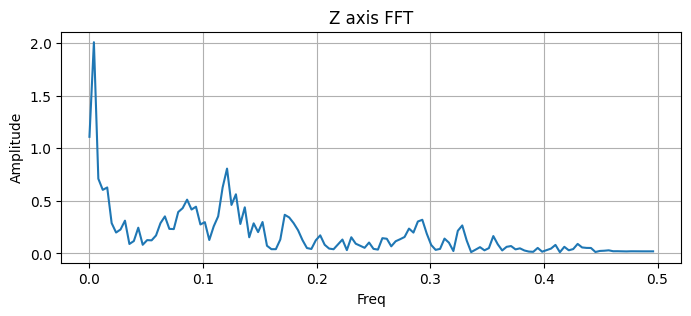

In [16]:
# ===========================
# FULL PIPELINE: CLEAN -> FEATURES -> TRAIN -> EVAL -> SAVE
# Uses uploaded file: /mnt/data/final.csv
# ===========================

# If running in Colab and missing packages, uncomment the next line:
# !pip install pywavelets joblib scikit-learn matplotlib scipy

import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import joblib
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ---------------------------
# CONFIG
# ---------------------------
FILEPATH = "/content/final.csv"   # <<< using your uploaded file path
WINDOW = 256
STRIDE = 128
RANDOM_STATE = 42
N_ESTIMATORS = 200

# ---------------------------
# 1) LOAD DATA
# ---------------------------
print("Loading:", FILEPATH)
df = pd.read_csv(FILEPATH)
print("Raw shape:", df.shape)
print("Sample labels (unique):", pd.unique(df["Output"])[:20])

# ---------------------------
# 2) MAP LABELS -> H,B,I,O,C
# ---------------------------
def map_label(x):
    if not isinstance(x, str):
        return None
    x = x.strip()
    if x.startswith("H"): return "H"
    # variants that include _B or start with B or contain "_B_"
    if "_B" in x or x.startswith("B"): return "B"
    if "_I" in x or x.startswith("I"): return "I"
    if "_O" in x or x.startswith("O"): return "O"
    # 'C' or 'combination' - a simple check
    if "C" in x or "comb" in x.lower(): return "C"
    return None

df["Class"] = df["Output"].apply(map_label)
print("Mapped classes (value counts):")
print(df["Class"].value_counts(dropna=False))

# drop rows with unmapped labels
df = df.dropna(subset=["Class"]).reset_index(drop=True)
print("After dropna shape:", df.shape)

# ---------------------------
# 3) FEATURE FUNCTIONS
# ---------------------------
def rms(sig):
    sig = np.array(sig).astype(float)
    return np.sqrt(np.mean(sig**2))

def crest_factor(sig):
    sig = np.array(sig).astype(float)
    peak = np.max(np.abs(sig))
    r = rms(sig)
    return peak / (r + 1e-12)

def peak_to_peak(sig):
    sig = np.array(sig).astype(float)
    return np.ptp(sig)

def mad(sig):
    sig = np.array(sig).astype(float)
    return np.mean(np.abs(sig - np.mean(sig)))

def wavelet_energy(sig, wavelet="db4", level=3):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    return sum(np.sum(c**2) for c in coeffs)

def wavelet_entropy(sig, wavelet="db4", level=3):
    coeffs = pywt.wavedec(sig, wavelet, level=level)
    energy = np.array([np.sum(np.abs(c)**2) for c in coeffs])
    energy_sum = np.sum(energy) + 1e-12
    p = energy / energy_sum
    # Shannon entropy
    return -np.sum(p * np.log(p + 1e-12))

def fft_band_energy(sig, fs=25600, bands=[(0,50),(50,500),(500,5000)]):
    # computes energy in frequency bands using rfft
    sig = np.array(sig).astype(float)
    N = len(sig)
    fft_vals = np.abs(np.fft.rfft(sig))
    freqs = np.fft.rfftfreq(N, d=1.0/fs)
    energies = []
    total = np.sum(fft_vals**2) + 1e-12
    for (low, high) in bands:
        mask = (freqs >= low) & (freqs < high)
        energies.append(np.sum(fft_vals[mask]**2) / total)
    return energies

from math import log2

# ---------------------------
# 4) EXTRACT FEATURES PER WINDOW
# ---------------------------
features_list = []
labels_list = []

print("Windowing and feature extraction (window=%d stride=%d)..." % (WINDOW, STRIDE))

n_rows = len(df)
i = 0
while i + WINDOW <= n_rows:
    win = df.iloc[i:i+WINDOW]
    x = win["X"].values
    y = win["Y"].values
    z = win["Z"].values
    lab = win["Class"].mode().iloc[0]  # majority label in the window

    # time-domain stats per axis
    feat = []
    for sig in (x,y,z):
        feat.append(np.mean(sig))
        feat.append(np.std(sig))
        feat.append(rms(sig))
        feat.append(skew(sig))
        feat.append(kurtosis(sig))
        feat.append(crest_factor(sig))
        feat.append(peak_to_peak(sig))
        feat.append(mad(sig))

    # FFT band energies (normalized) per axis (3 bands)
    bands = [(0,50),(50,500),(500,5000)]
    for sig in (x,y,z):
        feat.extend(fft_band_energy(sig, fs=25600, bands=bands))

    # wavelet energy & entropy per axis
    for sig in (x,y,z):
        feat.append(wavelet_energy(sig))
        feat.append(wavelet_entropy(sig))

    features_list.append(feat)
    labels_list.append(lab)
    i += STRIDE

features = np.array(features_list)
labels = np.array(labels_list)
print("Total windows:", features.shape[0], "Feature dim:", features.shape[1])

# ---------------------------
# 5) PREPARE & BALANCE CHECK
# ---------------------------
le = LabelEncoder()
y_enc = le.fit_transform(labels)

print("Class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))
for c in le.classes_:
    print(c, "count:", (labels==c).sum())

# ---------------------------
# 6) SCALE
# ---------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# ---------------------------
# 7) TRAIN/TEST SPLIT
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape)

# ---------------------------
# 8) TRAIN RANDOM FOREST (balanced)
# ---------------------------
print("Training RandomForest...")
rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)

# ---------------------------
# 9) EVALUATE
# ---------------------------
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# show feature importances (top 20)
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:20]
plt.figure(figsize=(10,4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), idx, rotation=90)
plt.title("Top feature indices by importance")
plt.show()

# ---------------------------
# 10) SAVE MODEL + SCALER + ENCODER
# ---------------------------
joblib.dump(rf, "rf_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(le, "label_encoder.joblib")
print("Saved rf_model.joblib, scaler.joblib, label_encoder.joblib")

# ---------------------------
# 11) QUICK TEST FUNCTION (predict one CSV file)
# ---------------------------
def predict_csv(file_path, model_loaded=None, scaler_loaded=None, encoder_loaded=None, show_fft=True):
    if model_loaded is None:
        model_loaded = joblib.load("rf_model.joblib")
    if scaler_loaded is None:
        scaler_loaded = joblib.load("scaler.joblib")
    if encoder_loaded is None:
        encoder_loaded = joblib.load("label_encoder.joblib")

    df_test = pd.read_csv(file_path)
    # if file includes Time_Col and other columns, ensure columns present
    required = ["X","Y","Z"]
    if not all(c in df_test.columns for c in required):
        raise ValueError("CSV must contain X,Y,Z columns")

    # compute features on full CSV as single window if large enough, else use sliding windows and majority vote
    n = len(df_test)
    if n < WINDOW:
        raise ValueError(f"Input file must have at least {WINDOW} rows. It has {n} rows.")

    feats = []
    labels_dummy = []
    i = 0
    while i + WINDOW <= n:
        win = df_test.iloc[i:i+WINDOW]
        x = win["X"].values; y = win["Y"].values; z = win["Z"].values

        feat = []
        for sig in (x,y,z):
            feat.append(np.mean(sig))
            feat.append(np.std(sig))
            feat.append(rms(sig))
            feat.append(skew(sig))
            feat.append(kurtosis(sig))
            feat.append(crest_factor(sig))
            feat.append(peak_to_peak(sig))
            feat.append(mad(sig))
        for sig in (x,y,z):
            feat.extend(fft_band_energy(sig, fs=25600, bands=bands))
        for sig in (x,y,z):
            feat.append(wavelet_energy(sig))
            feat.append(wavelet_entropy(sig))

        feats.append(feat)
        i += STRIDE

    feats = np.array(feats)
    feats_scaled = scaler_loaded.transform(feats)
    preds = model_loaded.predict(feats_scaled)
    pred_labels = encoder_loaded.inverse_transform(preds)

    # majority vote
    from collections import Counter
    vote = Counter(pred_labels)
    most_common_label, count = vote.most_common(1)[0]

    print("Window predictions distribution:", vote)
    print("Majority prediction:", most_common_label)

    if show_fft:
        def plot_fft(sig, title):
            N = len(sig)
            fft_vals = np.abs(np.fft.fft(sig))
            freqs = np.fft.fftfreq(N, 1.0)
            plt.figure(figsize=(8,3))
            plt.plot(freqs[:N//2], fft_vals[:N//2])
            plt.title(title)
            plt.xlabel("Freq")
            plt.ylabel("Amplitude")
            plt.grid()
            plt.show()
        print("Showing FFTs for first window")
        win0 = df_test.iloc[0:WINDOW]
        plot_fft(win0["X"].values, "X axis FFT")
        plot_fft(win0["Y"].values, "Y axis FFT")
        plot_fft(win0["Z"].values, "Z axis FFT")

    return most_common_label, vote

# ---------------------------
# 12) Example: Test your Ball CSV (if present at /mnt/data/Ball.csv)
# ---------------------------
ball_path_candidates = [
    "/mnt/data/Ball.csv",
    "/mnt/data/Ball (2).csv",
    "/mnt/data/Ball (3).csv",
    "/mnt/data/Ball (1).csv",
    "Ball.csv"
]
for p in ball_path_candidates:
    if os.path.exists(p):
        print("Testing:", p)
        pred_label, vote = predict_csv(p)
        break
else:
    print("No Ball.csv found at common paths. Use predict_csv('path/to/your/Ball.csv') to test.")


Window predictions distribution: Counter({np.str_('O'): 5, np.str_('I'): 2, np.str_('H'): 2, np.str_('B'): 1})
Majority prediction: O
Showing FFTs for first window


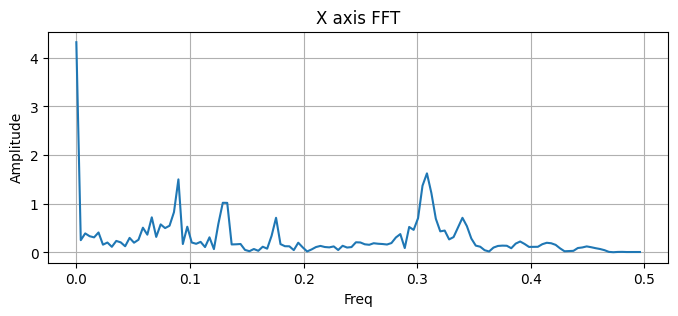

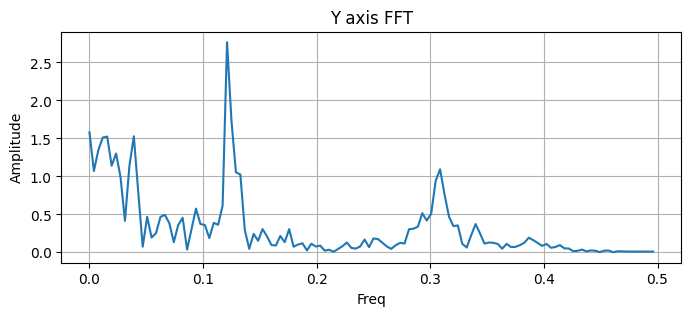

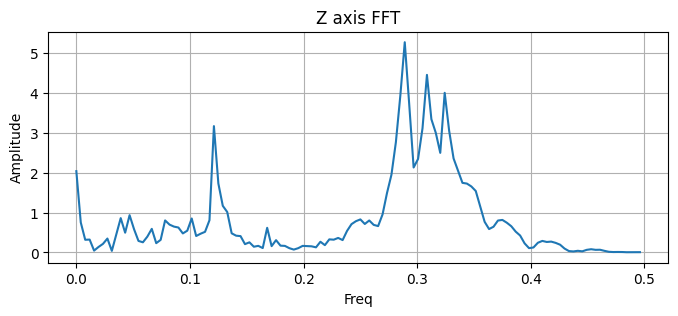

(np.str_('O'),
 Counter({np.str_('O'): 5, np.str_('B'): 1, np.str_('I'): 2, np.str_('H'): 2}))

In [19]:
predict_csv("/content/Outer_Race.csv")


Window predictions distribution: Counter({np.str_('I'): 1290, np.str_('B'): 98, np.str_('H'): 54, np.str_('O'): 48})
Majority prediction: I
Showing FFTs for first window


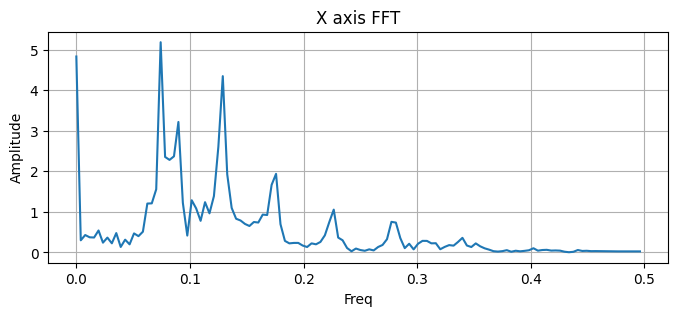

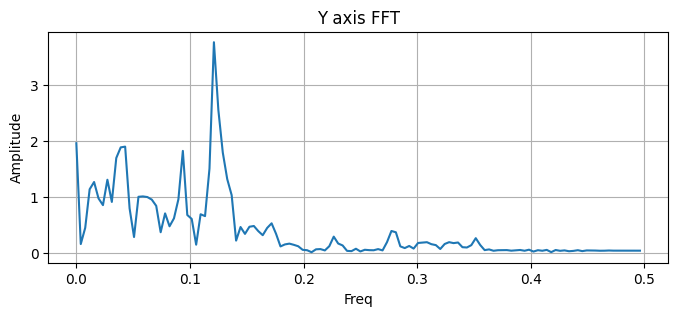

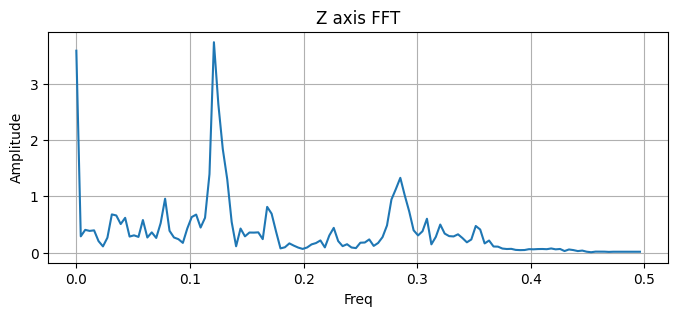

(np.str_('I'),
 Counter({np.str_('I'): 1290,
          np.str_('B'): 98,
          np.str_('H'): 54,
          np.str_('O'): 48}))

In [20]:
predict_csv("/content/InnerRaceFault_CLEAN.csv")

Window predictions distribution: Counter({np.str_('H'): 6})
Majority prediction: H
Showing FFTs for first window


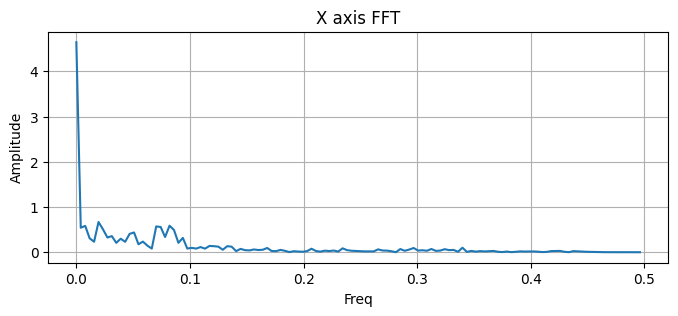

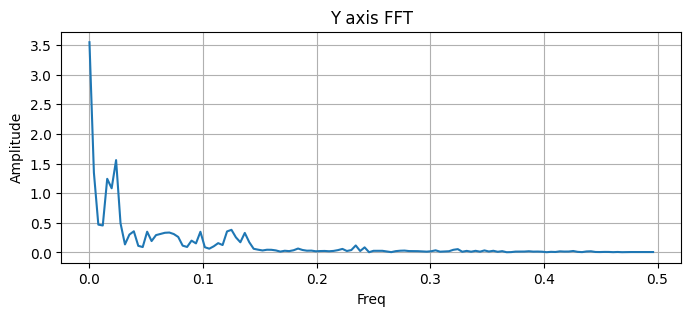

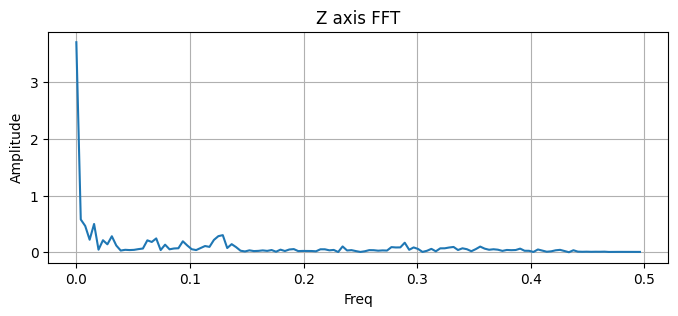

(np.str_('H'), Counter({np.str_('H'): 6}))

In [21]:
predict_csv("/content/H_20Hz.csv")